# **Preprocessing**

In [25]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer as SIA
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
from sklearn.base import clone
import numpy as np
from sklearn.model_selection import KFold

In [26]:
df = pd.read_csv(r"Reviews_withURL.csv")
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [27]:
sia = SIA()
df["Sentiment"] = df["Text"].apply(lambda x: 1 if sia.polarity_scores(x)["compound"] > 0 else -1)

In [ ]:
def segment_pos_tagging(text):
    
    text = re.sub("[0-9]|br|<|>|com|<br>", "", text, 0, re.MULTILINE)
    words = text.split()
    
    return nltk.tag.pos_tag(words)

df['TextSegment'] = df.Text.apply(segment_pos_tagging)

In [ ]:
def reconnect(text_segment):
    lemmatizer = WordNetLemmatizer()
    pos_tags = ['JJ', 'JJR', 'JJS']
    reconnect_adj = []
    
    for i in range(len(text_segment)):
        if text_segment[i][1] in pos_tags:
            adj = text_segment[i][0]
            adj = adj.replace(' ', '').replace(',','').replace(' ','').replace('/', '').replace('_', '')
            # adj = lemmatizer.lemmatize(adj, pos="a")
            if text_segment[i][1] == 'JJ':
                adj = lemmatizer.lemmatize(adj, pos="v")
            elif text_segment[i][1] == 'JJR':
                adj = lemmatizer.lemmatize(adj, pos="a")
            elif text_segment[i][1] == 'JJS':
                adj = lemmatizer.lemmatize(adj, pos="a")
            if len(adj) >= 4:

                if text_segment[i-1][0] == 'not':
                    reconnect_adj.append(f'not_{adj}')
                
                else:
                    reconnect_adj.append(adj)
            
            else:
                pass
    
    return " ".join(text for text in reconnect_adj)

df['TextAdj'] = df.TextSegment.apply(reconnect)

In [ ]:
df.to_csv(r"Reviews_withURL_preprocessing_v1.csv", index=False)

In [7]:
df.to_csv(r"Reviews_withURL_preprocessing.csv", index=False)

# **Training**

In [9]:
import pandas as pd

df = pd.read_csv(r"Reviews_withURL_preprocessing_v1.csv")

In [10]:
stemmer = PorterStemmer()
df['TextAdj'] = df['TextAdj'].apply(lambda x :[stemmer.stem(i) for i in str(x).split(' ')])

In [11]:
df['TextAdj'] = df['TextAdj'].apply(lambda x:' '.join(x))

In [12]:
df = df[df["HelpfulnessDenominator"] > 3]

In [13]:
# df["HelpfulnessDenominator"].value_counts()

In [14]:
df = df[df["HelpfulnessNumerator"] < df["HelpfulnessDenominator"]]
df["HelpfulnessRatio"] = df["HelpfulnessNumerator"] / df["HelpfulnessDenominator"]

In [15]:
def to_helpfulness_class(row):
    threshold = 0.65
    # if row["HelpfulnessRatio"] > threshold:
    #     return "Helpful"
    # else:
    #     return "Unhelpful"
    if row["HelpfulnessRatio"] > threshold and row["Sentiment"] == 1:
        return "HelpfulPos"
    elif row["HelpfulnessRatio"] > threshold and row["Sentiment"] == -1:
        return "HelpfulNeg"
    elif row["HelpfulnessRatio"] <= threshold and row["Sentiment"] == 1:
        return "UnhelpfulPos"
    elif row["HelpfulnessRatio"] <= threshold and row["Sentiment"] == -1:
        return "UnhelpfulNeg"
    
def to_emotion_class(row):
    if row["Sentiment"] == 1:
        return "Pos"
    elif row["Sentiment"] == -1:
        return "Neg"

df['HelpfulnessClass'] = df.apply(to_helpfulness_class, axis=1)
df['EmotionClass'] = df.apply(to_emotion_class, axis=1)


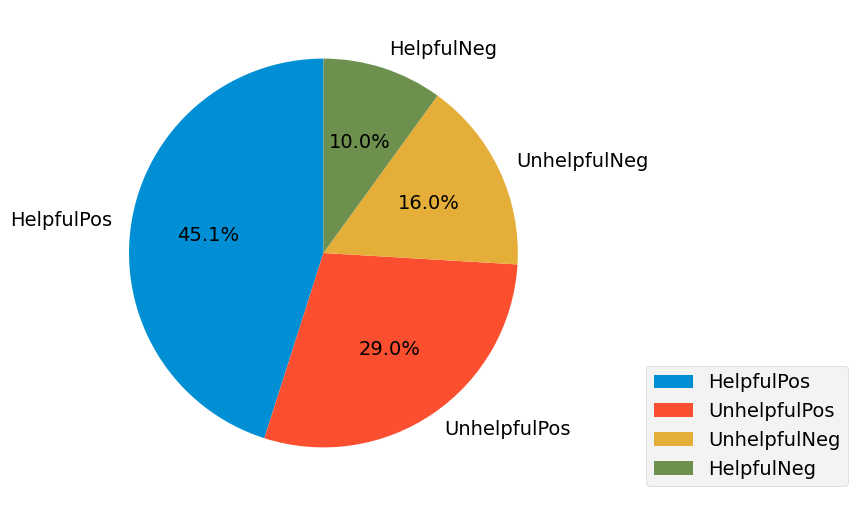

In [16]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(facecolor='#fff', figsize=(7, 6))
plt.pie(df['HelpfulnessClass'].value_counts(), labels=df['HelpfulnessClass'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0, 0.6, 1))

In [17]:
df['HelpfulnessClass'].value_counts()

HelpfulPos      24502
UnhelpfulPos    15748
UnhelpfulNeg     8671
HelpfulNeg       5426
Name: HelpfulnessClass, dtype: int64

In [18]:
df['EmotionClass'].value_counts()

Pos    40250
Neg    14097
Name: EmotionClass, dtype: int64

In [ ]:
df['Text']

,TextAdj,Sentiment,HelpfulnessNumerator,HelpfulnessDenominator,HelpfulnessRatio,HelpfulnessClass,EmotionClass
14,guilti,1,4,5,0.800000,HelpfulPos,Pos
15,nan,1,4,5,0.800000,HelpfulPos,Pos
50,nan,-1,0,7,0.000000,UnhelpfulNeg,Neg
60,good,1,2,4,0.500000,UnhelpfulPos,Pos
100,onli heavy.,1,4,5,0.800000,HelpfulPos,Pos
...,...,...,...,...,...,...,...
568388,mani altern sugar sugari same regular subtl su...,1,5,6,0.833333,HelpfulPos,Pos
568403,stick-form thin plastic not_sur open other eat...,1,0,6,0.000000,UnhelpfulPos,Pos
568405,easi tast good.,1,3,5,0.600000,UnhelpfulPos,Pos
568417,best abl,1,2,4,0.500000,UnhelpfulPos,Pos


In [19]:
df.fillna("", inplace=True)

In [20]:
from sklearn.model_selection import train_test_split as TTS
from sklearn.preprocessing import LabelEncoder
X = df.TextAdj
y = df.HelpfulnessClass
lb = LabelEncoder()
y = lb.fit_transform(y)
X_train, X_test, y_train, y_test = TTS(X, y, test_size=0.3, random_state=42)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df=0.0001)
# vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df=0.0001, max_df=0.99)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [23]:
for i in vectorizer.get_feature_names_out():
    print(i)

abdomin
abl
abnorm
about
abov
above
absent
absolut
absorb
absorbed
absorpt
absurd
abund
acai
accept
acceptable
access
accid
accordingly
account
accur
accuracy
accurate
accustom
acesulfam
acet
acetyl
acid
acidic
acidophilu
acids
acn
acplish
acquir
acrid
act
activ
active
actual
actually
acut
ad
add
added
addict
addicted
addicting
addictive
addit
addition
additives
adequ
adhes
adhesion
adjust
admir
admit
ador
adren
adult
adults
advanc
advance
adventur
advers
advertis
advertised
advertisement
advertising
advic
advice
advis
advised
aerogarden
affect
affected
afford
affordable
aforement
afraid
african
aft
after
afteral
afterlif
afternoon
aftertast
aftertaste
afterward
afterwards
again
agav
agave
age
ages
aggress
agil
ago
agre
agress
agricultur
ahead
ahold
aid
ain
ainer
air
airi
airtight
airy
akin
al
ala
alaskan
alcohol
alerg
alert
algae
alien
alittl
aliv
alive
alka
alkali
alkalin
alkaline
all
alleg
allerg
allergen
allergenic
allergi
allergies
allergy
allow
allowed
almond
almonds
almost
alon


In [21]:
# # # vectorizer.get_feature_names_out().shape
# from imblearn.under_sampling import ClusterCentroids

# cc = ClusterCentroids(random_state=0)
# X_train_resampled, y_train_resampled = cc.fit_resample(X_train_tfidf, y_train)

In [22]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
import pickle

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_tfidf, y_train)

model_name = '4class.sav'
pickle.dump(rfc, open(model_name, 'wb'))

In [23]:
# y_pred = rfc.predict(X_test_tfidf)

model_name = '4class.sav'

model = pickle.load(open(model_name, 'rb'))
y_pred = model.predict(X_test_tfidf)

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))
print("Recall Score: ", recall_score(y_test, y_pred, average='weighted'))

Accuracy:  0.6620055197792089
Confusion Matrix: 
 [[ 594  547  235  248]
 [  53 6460  232  641]
 [  84  622 1361  490]
 [  67 2026  266 2379]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.37      0.49      1624
           1       0.67      0.87      0.76      7386
           2       0.65      0.53      0.59      2557
           3       0.63      0.50      0.56      4738

    accuracy                           0.66     16305
   macro avg       0.67      0.57      0.60     16305
weighted avg       0.66      0.66      0.65     16305

Recall Score:  0.6620055197792089


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier


# 建立基礎分類器
estimators = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('xgb', XGBClassifier())
]

# 建立堆疊分類器
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(random_state=42)
)

# 訓練堆疊分類器
stacking_classifier.fit(X_train_tfidf, y_train)

# 在測試集上進行預測
y_pred = stacking_classifier.predict(X_test_tfidf)

# 評估預測結果
accuracy = stacking_classifier.score(X_test_tfidf, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.6580803434529285


In [26]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# # X_train, X_test, y_train, y_test = TTS(df["Text"], df["Helpfulness"], test_size=0.3, random_state=42)

# vectorizer = TfidfVectorizer(
#     min_df=0.0001,
#     # ngram_range=(1, 1), 
#     # stop_words='english'
# )
# vectorizer.fit(df["TextAdj"].values)

In [27]:
# for i in vectorizer.get_feature_names_out():
#     print(i)